In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed May  8 14:23:13 2019

@author: anqil
"""

from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

# load IRIS data from osiris services

In [16]:
#%% load IRIS data
#channel = 2
#orbit = 6434
#orbit = 22873
channel = 3
orbit = 20900

ir = open_level1_ir(orbit, channel, valid=False)
tan_alt = ir.l1.altitude
tan_lat = ir.l1.latitude
tan_lon = ir.l1.longitude
sc_look = ir.l1.look_ecef
sc_pos = ir.l1.position_ecef
l1 = ir.data
mjd = ir.mjd.data
pixel = ir.pixel.data


#%% clip data
#====drop data below and above some altitudes
top = 110e3
bot = 60e3
l1 = l1.where(tan_alt<top).where(tan_alt>bot)

#im_lst = np.arange(300,350,5)
im_lst = np.arange(2350,2425,5)
pix_lst = np.arange(22, 128)
im = 5
label_interval = 10

print(num2date(ir.mjd[0],units))
print('number of images: ', len(im_lst))

2004-12-24 07:57:46.975720
number of images:  15


# interpolate pixel data into altitude space

<Figure size 432x288 with 0 Axes>

/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


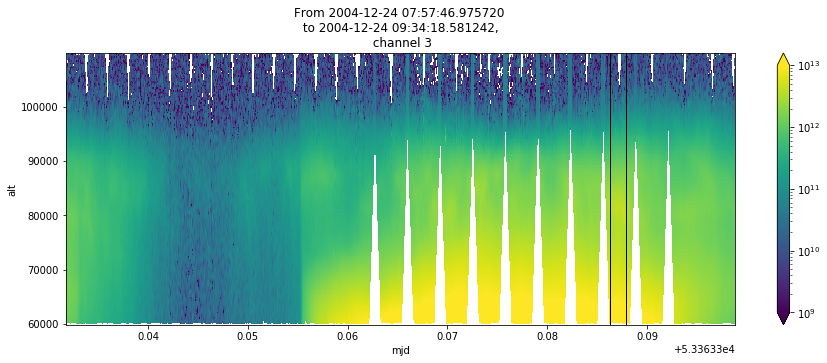

<Figure size 432x288 with 0 Axes>

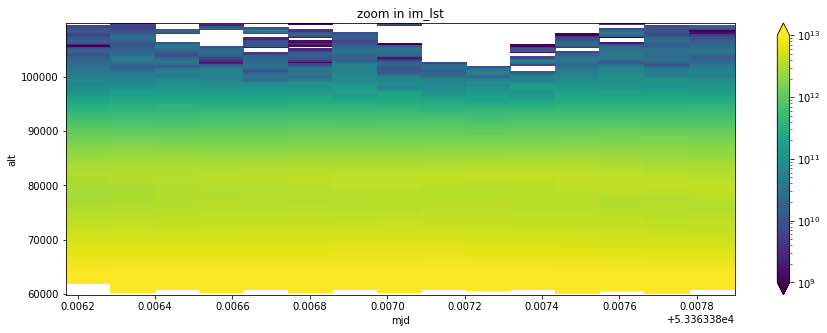

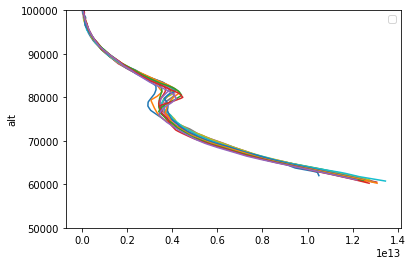

In [17]:
#%% pixel -> altitude space and plot
alts_interp = np.arange(bot, top, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=(mjd, alts_interp), 
                           dims=('mjd', 'alt'))

plt.figure()
data_interp.plot(x='mjd', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), channel))
plt.axvline(x=mjd[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=mjd[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(mjd=im_lst).plot(x='mjd', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst')
plt.show()

plt.figure()
data_interp.isel(mjd=im_lst).plot.line(y='alt')
plt.ylim([50e3, 100e3])
plt.legend([])
plt.title('limb radiance')

# set retrieval grid

In [18]:
#%% retrieval grid
z = np.arange(bot, top, 2e3) # m
z_top = z[-1] + 2e3

# load SMR data

In [22]:
#%% load SMR Ozone
import requests 
import numpy as np
import json
import sqlite3 as sql
import matplotlib.pylab as plt

start_year = num2date(ir.isel(mjd=im_lst).mjd, units)[0].year
end_year = num2date(ir.isel(mjd=im_lst).mjd, units)[-1].year
start_month = num2date(ir.isel(mjd=im_lst).mjd, units)[0].month
end_month = num2date(ir.isel(mjd=im_lst).mjd, units)[-1].month
start_day = num2date(ir.isel(mjd=im_lst).mjd, units)[0].day
end_day = num2date(ir.isel(mjd=im_lst).mjd, units)[-1].day
start_hour = num2date(ir.isel(mjd=im_lst).mjd, units)[0].hour
end_hour = num2date(ir.isel(mjd=im_lst).mjd, units)[-1].hour
start_minute = num2date(ir.isel(mjd=im_lst).mjd, units)[0].minute
end_minute = num2date(ir.isel(mjd=im_lst).mjd, units)[-1].minute

start_date = '{}-{}-{}%20{}%3A{}%3A00'.format(start_year, start_month, 
              start_day, start_hour, start_minute)
end_date = '{}-{}-{}%20{}%3A{}%3A59'.format(end_year, end_month, end_day, 
            end_hour, end_minute)

dataset = 'ALL'
fm = 2
baseurl = "http://odin.rss.chalmers.se/rest_api/v5/level2/development/"
scansurl = baseurl+"{0}/{1}/scans/?limit=1000&offset=0&"
scansurl += "start_time={2}&end_time={3}"
a = requests.get(scansurl.format(dataset,fm,start_date,end_date))
aaa = json.loads(a.text)
scanno = aaa['Data'][0]['ScanID']
product = "O3 / 545 GHz / 20 to 85 km"
baseurl = "http://odin.rss.chalmers.se/rest_api/v5/level2/development/"
scansurl = baseurl+"{0}/{1}/{2}/L2/?product={3}"
a = requests.get(scansurl.format(dataset,fm,scanno,product))
result = json.loads(a.text)['Data'][0]

o3_vmr_a = np.array(result['Apriori'])
o3_vmr = np.array(result['VMR'])
z_smr = np.array(result['Altitude'])
p_smr = np.array(result['Pressure'])
T_smr = np.array(result['Temperature'])
Av = 6.023e23 #Avogadro's number: molec/mol
R = 8.31 # gas constant: J/mol/K
m = Av * p_smr / (R * T_smr) * 1e-6# number density of air
o3_smr = m * o3_vmr  # cm-3
o3_smr_a = m * o3_vmr_a # cm-3

# interpolate into the retrieval grid
o3_SMR = interp1d(z_smr, o3_smr)(z)
o3_SMR_a = interp1d(z_smr, o3_smr_a)(z)
T_SMR = interp1d(z_smr, T_smr)(z)
m_SMR = interp1d(z_smr, m)(z)

# IRIS 1D inversion 
#### -using SMR o3 apriori to calculate o2(^1 \Delta) volume emission rate profile as apriori
#### -choice of Se and Sa is abritrary for now

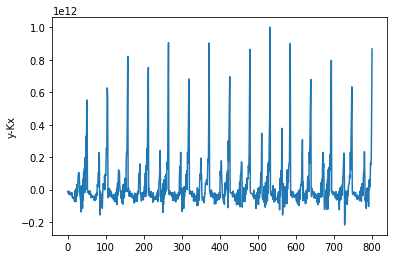

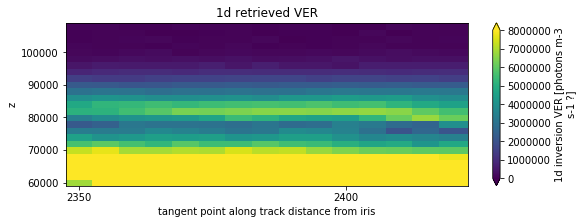

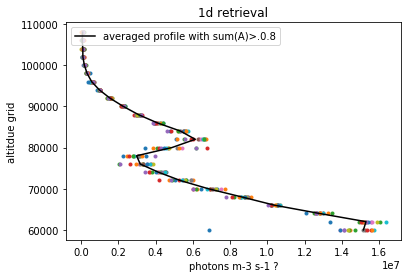

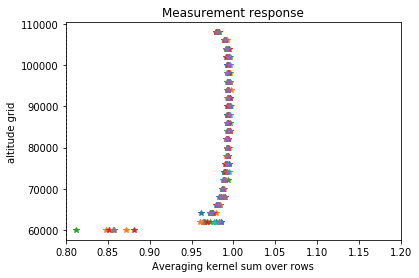

In [20]:
#%% 1D inversion 
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris
from chemi import cal_o2delta, gfactor
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

# calculate sun zenith angle
loc = coord.EarthLocation(lon=tan_lon.isel(mjd=im_lst[im],pixel=60) * u.deg,
                          lat=tan_lat.isel(mjd=im_lst[im],pixel=60) * u.deg)
now = Time(ir.mjd.isel(mjd=im_lst[im]), format='mjd', scale='utc')
altaz = coord.AltAz(location=loc, obstime=now)
sun = coord.get_sun(now)
zenithangle = 90 - sun.transform_to(altaz).alt.deg

gA = gfactor(0.21*m_SMR, T_SMR, z, zenithangle)
xa = cal_o2delta(o3_SMR_a, T_SMR, m_SMR, z, zenithangle, gA) *2.58e-4
#xa = np.ones(len(z)) *0 # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Ave = []
resi = []
result_1d = np.zeros((len(im_lst), len(z)))
for i in range(len(im_lst)):
    h = tan_alt.isel(mjd=im_lst[i], pixel=tan_alt.pixel[l1.notnull().isel(mjd=im_lst[i])])
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(mjd=im_lst[i], pixel=tan_alt.pixel[l1.notnull().isel(mjd=im_lst[i])]).data
#    Se = np.diag(np.ones(len(y))) * (1e12)**2
    Se = np.diag(np.ones(len(y))) *30
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 
    resi.extend(y-K.dot(x))


result_1d = xr.DataArray(result_1d, 
                         coords=(mjd[im_lst], z), 
                         dims=('mjd', 'z'))
result_1d.attrs['units'] = 'photons cm-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
mr_threshold = 0.8
result_1d_mean = result_1d.where(Ave>mr_threshold).mean(dim='mjd')


#==== plot residual
plt.figure()
plt.plot(np.array(resi).ravel())
plt.ylabel('y-Kx')

#==== plot VER contour
#result_1d = abs(result_1d)
result_1d.plot(x='mjd', y='z', 
#               norm=LogNorm(), 
               vmin=0, vmax=8e6, 
               size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='tangent point along track distance from iris')
#ax.set_xticks(mjd[im_lst])
#ax.set_xticklabels(np.round(tan_beta.sel(pixel=60).data*Re))
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
plt.show()

#==== plot VER in 1D
plt.figure()
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with sum(A)>.{}'.format(mr_threshold))
ax.set_xscale('linear')
ax.set(#xlim=[1e4, 1e8],
       xlabel=result_1d.units, 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend(loc='upper left')
plt.show()

#==== plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('Averaging kernel sum over rows')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([mr_threshold, 1.2])
plt.axvline(x=mr_threshold, ls=':', color='k')
#plt.text(mr_threshold, z[-1], 'threshold')
plt.show()

`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 4.3077e+21, final cost 7.2085e-10, first-order optimality 2.92e+05.


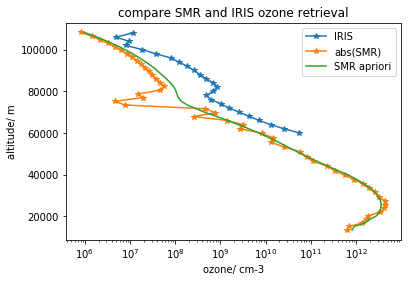

In [23]:
#%% lsq fit
from chemi import cal_o2delta, cal_o2delta_thomas
from scipy.optimize import least_squares

def residual(o3, T, m, z, zenithangle, gA, o2delta_meas):
    o2delta_model = cal_o2delta_thomas(o3, T, m, z, zenithangle, gA)    
    return o2delta_meas - o2delta_model

o3_init = interp1d(z_smr, o3_smr_a)(z)
o2delta_meas = result_1d.isel(mjd=5) / 2.58e-4 # cm-3?
res_lsq = least_squares(residual, o3_init, bounds=(0, np.inf), verbose=1, 
                        args=(T_SMR, m_SMR, z, zenithangle, gA, o2delta_meas))
o3_iris = res_lsq.x

#%% compare
plt.figure()
plt.plot(o3_iris, z, '*-', label='IRIS')
plt.plot(abs(o3_smr), z_smr, '*-', label='abs(SMR)')
plt.plot(o3_smr_a, z_smr, label='SMR apriori')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
ax.set(xlabel='ozone/ cm-3',
       ylabel='altitude/ m',
       title='compare SMR and IRIS ozone retrieval')
#plt.xlim([o3_init.min(), o3_init.max()])
plt.show()